<a href="https://colab.research.google.com/github/DepartmentOfStatisticsPUE/cda-2022/blob/main/notebooks/cda_4_gof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

### Python libraries

In [1]:
import scipy.stats as st
from scipy.optimize import minimize
import numpy as np
import pandas as pd

## Setup R via Python

In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("vcd")
install.packages("fitdistrplus")

In [4]:
%%R
library(vcd)
library(fitdistrplus)

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: survival



## Setup Julia via Python

In [ ]:
%%bash
wget -q https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz
tar zxvf julia-1.7.2-linux-x86_64.tar.gz
## python's module
pip install julia

In [6]:
import julia
julia.install(julia = "/content/julia-1.7.2/bin/julia")
from julia import Julia
jl = Julia(runtime="/content/julia-1.7.2/bin/julia",compiled_modules=False)
%load_ext julia.magic


Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.

PyCall is setup for non-default Julia runtime (executable) `/content/julia-1.7.2/bin/julia`.
To use this Julia runtime, PyJulia has to be initialized first by
    from julia import Julia
    Julia(runtime='/content/julia-1.7.2/bin/julia')


Initializing Julia interpreter. This may take some time...


/usr/local/lib/python3.7/dist-packages/julia/magic.py:166: UserWarning: Incompatible upstream libraries. Got ImportError: No module named 'prompt_toolkit.lexers'
  warnings.warn(template.format(err))
/usr/local/lib/python3.7/dist-packages/julia/magic.py:174: UserWarning: Incompatible upstream libraries. Got ImportError: cannot import name 'Completion' from 'IPython.core.completer' (/usr/local/lib/python3.7/dist-packages/IPython/core/completer.py)
  warnings.warn(template.format(err))


In [ ]:
%%julia
using Pkg
Pkg.add("Distributions")
Pkg.add("Optim")
Pkg.add("HypothesisTests")
Pkg.add("StatsBase")
using Distributions
using Random
using HypothesisTests
using Optim
using StatsBase
using DelimitedFiles

In [8]:
%%julia
Pkg.status()

      Status `~/.julia/environments/v1.7/Project.toml`
  [31c24e10] Distributions v0.25.52
  [09f84164] HypothesisTests v0.10.8
  [429524aa] Optim v1.6.2
  [438e738f] PyCall v1.93.1
  [2913bbd2] StatsBase v0.33.16


## Solution in R

In [18]:
%%R
set.seed(1)
n <- 10000
x <- rnbinom(n, mu = 3, size = 2)
x_fitted <- fitdistr(x = x, densfun = "negative binomial")
x_fitted

      size          mu    
  2.01336939   3.00049449 
 (0.05148793) (0.02733434)


In [10]:
%%R
cat(x, sep = "\n", file = "nb_sim.txt")

Small note regarding the `vcd` package. It gives correct answers but in a slightly different way.

1. `goodfit` function returns a list with `fitted` (expected) frequencies under a given distribution using `pdf` of this distribution
2. `summary(goodfit object)` returns a $\chi^2$ and $G^2$ tests using `cdf` of a given distribution. 

Thus, if we use `object$fitted` created by `goodfit` to calculate $\chi^2$ and $G^2$ statistics by hand we will get slightly different statistics values than the one returned by `summary.goodfit()` function. Thus, both are accepted results. 

In this material, we use the first approach in Python and Julia.

In [13]:
%%R
gof_nb <- goodfit(x, "nbinomial")
gof_po <- goodfit(x, "poisson")
gof_nb


Observed and fitted values for nbinomial distribution
with parameters estimated by `ML' 

 count observed       fitted pearson residual
     0     1583 1592.9576699     -0.249491416
     1     1969 1919.3226642      1.133924923
     2     1699 1730.5759462     -0.759033671
     3     1356 1385.4754570     -0.791883200
     4     1025 1039.1753710     -0.439733965
     5      748  747.9232225      0.002807408
     6      565  523.1819782      1.828256376
     7      357  358.4183143     -0.074916483
     8      244  241.6616132      0.150422398
     9      164  160.9035748      0.244105604
    10      111  106.0489061      0.480781851
    11       54   69.3104364     -1.839027630
    12       45   44.9808274      0.002858694
    13       24   29.0166287     -0.931297590
    14       23   18.6216166      1.014623922
    15       12   11.8967720      0.029928364
    16       11    7.5704166      1.246468975
    17        6    4.8004960      0.547467895
    18        2    3.0345408     -0

In [12]:
%%R
summary(gof_nb)
summary(gof_po)


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df  P(> X^2)
Likelihood Ratio 21.27568 18 0.2657337

	 Goodness-of-fit test for poisson distribution

                      X^2 df P(> X^2)
Likelihood Ratio 5112.284 19        0


Note that we may use $\chi^2$ test but the degrees of freedom and p-value is incorrect as it does not account for number of parameters. For the $\chi^2$ we also use only the non-zero count values.

In [35]:
%%R
flag <- gof_nb$observed > 0

chisq.test(x = gof_nb$observed[flag], 
           p = gof_nb$fitted[flag]/sum(gof_nb$fitted[flag])) 


	Chi-squared test for given probabilities

data:  gof_nb$observed[flag]
X-squared = 14.509, df = 20, p-value = 0.8038



In [38]:
%%R
chisq.test(x = gof_nb$observed[flag], 
           p = dnbinom(x = gof_nb$count[flag], 
                       size = x_fitted$estimate[1],
                       mu = x_fitted$estimate[2]), 
           rescale.p = TRUE) 


	Chi-squared test for given probabilities

data:  gof_nb$observed[flag]
X-squared = 14.509, df = 20, p-value = 0.8038



We need to correct p-value

In [39]:
%%R
pchisq(14.509, 18, lower.tail = FALSE)

[1] 0.6953586


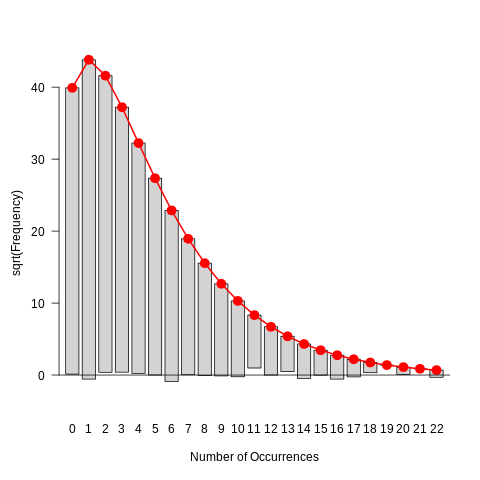

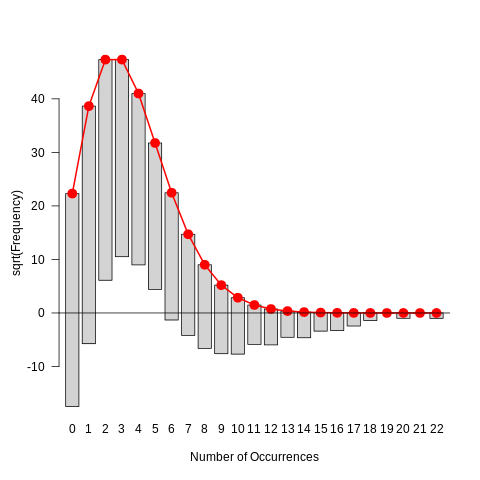

In [22]:
%%R
rootogram(gof_nb)
rootogram(gof_po)

## Solution in Python

Python uses a different specification of negative binomial than we specified in R so we need to rewrite it as follows: 

$$
p = \frac{\text{size}}{\text{size} + \mu}.
$$

In [23]:
np.random.seed(1)
N = 1000
x = st.nbinom(n = 2, p = 2/(2+3)).rvs(N)
np.mean(x)

3.09

However, these pseudo-random numbers are not the same as in R. So, to make our example comparable with R, we read data generated from R that was saved to text file.

In [24]:
x = np.loadtxt("nb_sim.txt", dtype = np.int64)
np.mean(x)

3.0006

Optimization using pmf function

In [25]:
def pdf_nbinom(par, x):
  pdfnbinom = st.nbinom(par[0],par[1]).logpmf(x)
  return -np.sum(pdfnbinom)

res = minimize(fun=pdf_nbinom, x0=[2, 0.5], args = (x), method = "Nelder-Mead")
res

 final_simplex: (array([[2.01357331, 0.40157875],
       [2.0136646 , 0.40158661],
       [2.01348695, 0.40156478]]), array([22061.74799012, 22061.74799024, 22061.74799191]))
           fun: 22061.747990122178
       message: 'Optimization terminated successfully.'
          nfev: 76
           nit: 40
        status: 0
       success: True
             x: array([2.01357331, 0.40157875])

**Goodness of fit -- step by step**

$G^2$ and $\chi^2$ GoF can be calculated using `scipy.stats.power_divergence` function

In [61]:
x_uniq_vals, x_uniq_counts = np.unique(x, return_counts=True)
## we simply use pdf(NB(2.01357331, 0.40157875), x) 
est_pdf = st.nbinom(res.x[0],res.x[1]).pmf(x_uniq_vals) 
## probs are not summing to 1 - rescale
est_pdf = est_pdf/np.sum(est_pdf) 

$G^2$ test

In [62]:
st.power_divergence(x_uniq_counts, 
                    sum(x_uniq_counts)*est_pdf, 
                    lambda_ = 0, ddof = 2)

Power_divergenceResult(statistic=14.378707061013243, pvalue=0.7040911371933183)

$\chi^2$ test

In [63]:
st.power_divergence(x_uniq_counts, 
                    sum(x_uniq_counts)*est_pdf, 
                    lambda_ = 1, ddof = 2)

Power_divergenceResult(statistic=14.510966027945067, pvalue=0.695226354877517)

**Rootograms** are not available in python. There are some scripts that recreate this plot using `matplotlib`, see

https://stackoverflow.com/questions/38252879/how-to-plot-a-hanging-rootogram-in-python



## Solution in Julia

In [50]:
%%julia
Random.seed!(123)
n = 1000
x = rand(NegativeBinomial(2, 2/(2+3)), n)
mean(x)

3.026

However, these pseudo-random numbers are not the same as in R. So, to make our example comparable with R, we read data generated from R that was saved to text file.

In [53]:
%%julia
x = readdlm("nb_sim.txt", Int)
x = vec(x)

array([3, 1, 1, ..., 3, 3, 3], dtype=int64)

In [54]:
%%julia
function llnb(par, data)
  ll = logpdf.(NegativeBinomial(par[1], par[2]), data)
  return -sum(ll)
end

res = optimize(par -> llnb(par, x), [2, 0.5])
res.minimizer

array([2.01360006, 0.40157958])

Goodness of fit statistics

In [66]:
%%julia
x_uniq_dict = sort(countmap(x))
x_uniq_vals = Int.(keys(x_uniq_dict))
x_uniq_counts = Int.(values(x_uniq_dict))
params = res.minimizer
est_pdf = pdf.(NegativeBinomial(params[1], params[2]), x_uniq_vals) ## not sum to 1 - rescale
est_pdf = est_pdf ./ sum(est_pdf)

array([1583, 1969, 1699, 1356, 1025,  748,  565,  357,  244,  164,  111,
         54,   45,   24,   23,   12,   11,    6,    2,    1,    1],
      dtype=int64)

In [ ]:
%%julia
ChisqTest(x_uniq_counts, est_pdf) ## this throws an error in colab

```julia
julia> ChisqTest(x_uniq_counts, est_pdf)
Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.159332, 0.191992, 0.173119, 0.138601, 0.103959, 0.0748225, 0.0523394, 0.0358562, 0.0241757, 0.0160966  …  0.00693355, 0.00449965, 0.00290263, 0.00186275, 0.00119003, 0.000757253, 0.000480175, 0.000303527, 0.000120296, 4.72388e-5]
    point estimate:          [0.1583, 0.1969, 0.1699, 0.1356, 0.1025, 0.0748, 0.0565, 0.0357, 0.0244, 0.0164  …  0.0054, 0.0045, 0.0024, 0.0023, 0.0012, 0.0011, 0.0006, 0.0002, 0.0001, 0.0001]
    95% confidence interval: [(0.1491, 0.1676), (0.1877, 0.2062), (0.1607, 0.1792), (0.1264, 0.1449), (0.0933, 0.1118), (0.0656, 0.0841), (0.0473, 0.0658), (0.0265, 0.045), (0.0152, 0.0337), (0.0072, 0.0257)  …  (0.0, 0.0147), (0.0, 0.0138), (0.0, 0.0117), (0.0, 0.0116), (0.0, 0.0105), (0.0, 0.0104), (0.0, 0.0099), (0.0, 0.0095), (0.0, 0.0094), (0.0, 0.0094)]

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.8037

Details:
    Sample size:        10000
    statistic:          14.510593683125506
    degrees of freedom: 20
    residuals:          [-0.258657, 1.12004, -0.77377, -0.805987, -0.452445, -0.00822523, 1.81864, -0.082495, 0.144257, 0.239165  …  -1.84171, 0.000526521, -0.932932, 1.0131, 0.0288963, 1.24553, 0.546826, -0.594231, -0.185051, 0.767654]
    std. residuals:     [-0.282106, 1.24602, -0.850924, -0.868412, -0.477971, -0.00855137, 1.86819, -0.0840149, 0.146033, 0.241114  …  -1.84813, 0.000527709, -0.934289, 1.01405, 0.0289135, 1.246, 0.546958, -0.594321, -0.185062, 0.767672]
```

Note that p-value is calculated wrongly as correct df is 18 not 20. So correct p-value is: 

In [72]:
%%julia
1-cdf(Chisq(18), 14.510593683125506)

0.6952513989555996